# Fitting

## Setup & Config

In [24]:
import uproot
import pandas as pd
import numpy as np
import scipy
import scipy.optimize as opt
import math
from matplotlib import pyplot as plt
import matplotlib as mpl

In [14]:
mpl.rc('font', family='sans-serif') 
mpl.rc('font', serif='Helvetica Neue') 
mpl.rcParams.update({'font.size': 18})
mpl.rcParams.update({'figure.dpi': 100})

pd.set_option('display.width', 200)

## Intro
In this section, we will be fitting the data to several histograms to try to extract the hypothetical invariant mass of the Higgs boson.

## Notebook Table of Contents:
* [Data](#a)
* 

## Data
Analysis will be done on 2011 and 2012 data in parallel.

#### Reading Data

In [3]:
# 2011
file_2011 = uproot.open("tree_TYPE_DATA_2011.root")
tree_2011 = file_2011["TYPE_DATA"]
df_2011 = tree_2011.arrays(library='pd')

# 2012
file_2012 = uproot.open("tree_TYPE_DATA_2012.root")
tree_2012 = file_2012["tree_TYPE_DATA"]
df_2012 = tree_2012.arrays(library='pd')

#### Reading Category Mapping Data
Loading the supplementary mapping csv

In [4]:
categ_mapping_2011 = pd.read_csv('categ_mapping_2011.csv', delimiter=',')
print(categ_mapping_2011)
categ_mapping_2012 = pd.read_csv('categ_mapping_2012.csv', delimiter=',')
print(categ_mapping_2012)

   label                    categ_name  sigma_cb  bin_width  bin_width_given  fwhm
0      1   Unconv. central, low p_{Tt}      1.45          4                2  3.41
1      2  Unconv. central, high p_{Tt}      1.37         12                4  3.22
2      3      Unconv. rest, low p_{Tt}      1.57          3                1  3.71
3      4     Unconv. rest, high p_{Tt}      1.43          7                2  3.36
4      5     Conv. central, low p_{Tt}      1.63          5                2  3.84
5      6    Conv. central, high p_{Tt}      1.48         14                4  3.48
6      7        Conv. rest, low p_{Tt}      1.79          3                1  4.23
7      8    Conv. central, high p_{Tt}      1.61          7                2  3.80
8      9              Conv. transition      2.27          4                1  5.52
9     10                         2-jet      1.52         13                4  3.59
   label                    categ_name  sigma_cb  bin_width_given  fwhm
0      1   Unco

#### Splitting Data
Dividing data into categories, where `index+1` is the category number (label)

In [5]:
inv_mass_2011 = [df_2011.loc[df_2011["categ_Model10Categories"]==i+1]["invariant_mass"] for i in range(10)]
inv_mass_2012 = [df_2012.loc[df_2012["categ_Model10Categories"]==i+1]["invariant_mass"] for i in range(10)]
inv_mass_2011[:2]

[4        119.114024
 9        137.494181
 30       131.245063
 68       136.011798
 76       104.488659
             ...    
 23736    133.061264
 23743    134.103974
 23764    117.092334
 23770    103.785302
 23780    109.134173
 Name: invariant_mass, Length: 2054, dtype: float64,
 319      105.970605
 954      137.870636
 1022     133.575895
 1047     156.404971
 1049     102.045109
             ...    
 22807    103.140680
 23112    102.602065
 23158    129.189734
 23524    112.024812
 23757    119.144201
 Name: invariant_mass, Length: 97, dtype: float64]

Histogram data for invariant mass for each category. `hist_[year]` array will be an array of DataFrames, where `index+1` is category number (label).<br>
Note that the `"bins"` column represents the BIN CENTERS, not the BIN EDGES.

In [79]:
hist_2011 = [pd.DataFrame({"n": hist[0], "bins": (hist[1][1:]+hist[1][:-1])/2, "yerr": np.sqrt(hist[0])}) for i in range(len(inv_mass_2011)) for bw in [categ_mapping_2011["bin_width_given"][i]] for hist in [np.histogram(inv_mass_2011[i],np.linspace(100, 160, int(60/bw)))]]
hist_2012 = [pd.DataFrame({"n": hist[0], "bins": (hist[1][1:]+hist[1][:-1])/2, "yerr": np.sqrt(hist[0])}) for i in range(len(inv_mass_2012)) for bw in [categ_mapping_2012["bin_width_given"][i]] for hist in [np.histogram(inv_mass_2012[i],np.linspace(100, 160, int(60/bw)))]]
display(hist_2011[0])

,n,bins,yerr
0,182,101.034483,13.490738
1,151,103.103448,12.288206
2,131,105.172414,11.445523
3,125,107.241379,11.180340
4,123,109.310345,11.090537
5,134,111.379310,11.575837
6,99,113.448276,9.949874
7,94,115.517241,9.695360
8,77,117.586207,8.774964
9,86,119.655172,9.273618


## Visualization
In this section, we work on visualizing the data.

#### Total
First, we will plot the histogram for total (uncategorized) invariant mass

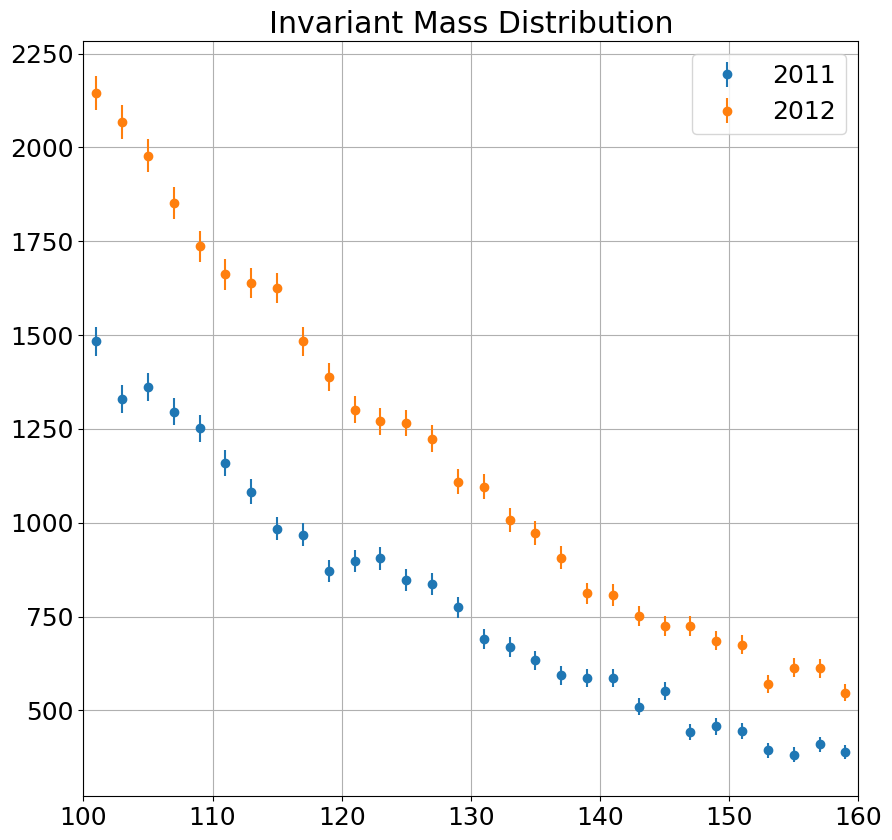

In [80]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("Invariant Mass Distribution")

n_total_2011, bin_total_2011 = np.histogram(df_2011["invariant_mass"], 30)
bin_centers_2011 = (bin_total_2011[1:]+bin_total_2011[:-1])/2
ax.errorbar(
    bin_centers_2011,
    n_total_2011,
    yerr=np.sqrt(n_total_2011),
    fmt='o',
    label="2011"
)

n_total_2012, bin_total_2012 = np.histogram(df_2012["invariant_mass"], 30)
bin_centers_2012 = (bin_total_2012[1:]+bin_total_2012[:-1])/2

ax.errorbar(
    bin_centers_2012,
    n_total_2012,
    yerr=np.sqrt(n_total_2012),
    fmt='o',
    label="2012"
)

ax.legend()
ax.set_xlim(100,160)
ax.grid()

#### Categorical Histograms
Next, we will plot the categorical invariant mass

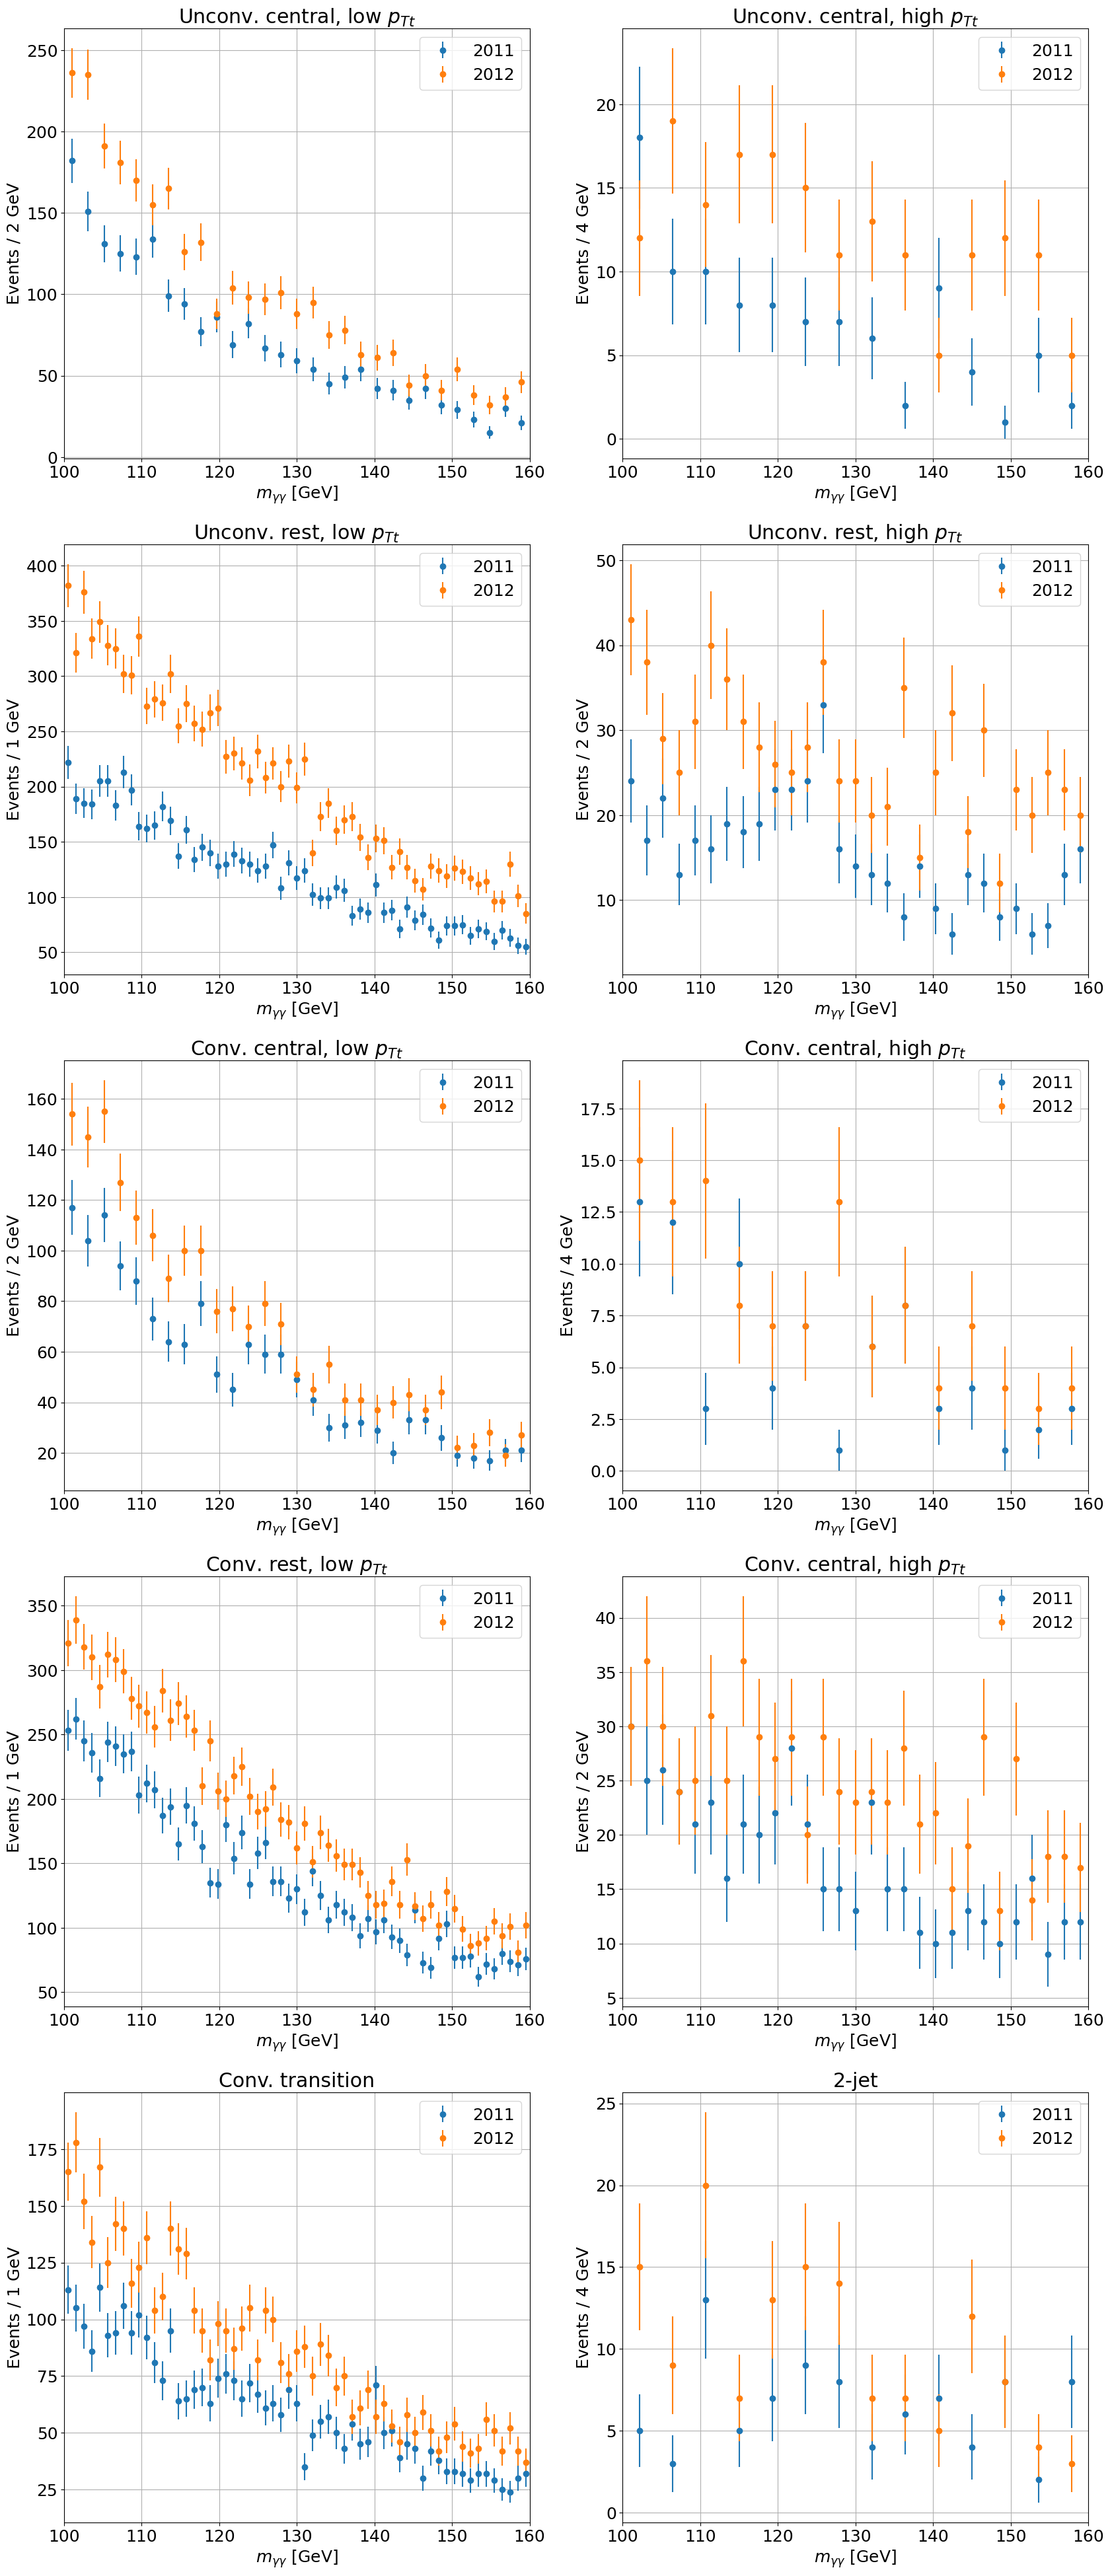

In [82]:
fig1, ax1 = plt.subplots(5, 2, figsize=(20, 50))

for i, ax in enumerate(fig1.axes):
    title = categ_mapping_2011["categ_name"][i].replace("p_{Tt}", "$p_{Tt}$")
    ax.set_title(r"{}".format(title))
    ax.set_xlabel(r"$m_{\gamma\gamma}$ [GeV]")
    ax.set_ylabel("Events / {} GeV".format(categ_mapping_2011["bin_width_given"][i]))
    ax.errorbar(
        hist_2011[i]["bins"],
        hist_2011[i]["n"],
        yerr=hist_2011[i]["yerr"],
        fmt='o',
        label="2011"
    )
    ax.errorbar(
        hist_2012[i]["bins"],
        hist_2012[i]["n"],
        yerr=hist_2012[i]["yerr"],
        fmt='o',
        label="2012"
    )
    ax.legend()
    ax.set_xlim(100,160)
    ax.grid(True)

## Processing
Before performing analysis, we need to process the data.

#### Exclusion Function
In order to fit a background, we need to exclude the hypothetical Higgs region. We will create a function that returns histogram data with an excluded region that is specified by the user.

In [84]:
def hist_exclude(df, left, right):
    """
    df should have columns "n" and "bins"
    Return: df with NO data in left<bins<right
    """
    if left >= right:
        return None
    return df.loc[(left>df["bins"]) ^ (df["bins"]>right)]

#### Exclusion Array Function
We will now create a function that takes in an array of DataFrames representing histogram data, and excludes the specified region in each array.

In [85]:
def exclude_array(df_arr, left, right):
    """
    df_arr should have DataFrames, where each as columsn "n", "bins"
    Return: array with DataFrames with excluded region
    """
    return [hist_exclude(df, left, right) for df in df_arr]

#### Sliding Exclusion
In order to eliminate a priori bias, we will exclude many different regions. We will have a total of 6 regions from 100 to 160 with a width of 10. Each histogram of excluded regions will be put into an array.

In [86]:
widths = np.linspace(100, 160, 7, dtype=int)
excluded_2011 = [exclude_array(hist_2011, widths[i], widths[i+1]) for i in range(len(widths)-1)]
excluded_2012 = [exclude_array(hist_2012, widths[i], widths[i+1]) for i in range(len(widths)-1)]

For example, the 7th category (conv. rest low ptt) of the 2012 data with an exclusion region of 140-150 would be accessed as follows:

In [87]:
excluded_2012[4][6].head()

,n,bins,yerr
0,321,100.508475,17.916473
1,339,101.525424,18.411953
2,318,102.542373,17.832555
3,310,103.559322,17.606817
4,287,104.576271,16.941074


## Fitting
At this point, we have the data that we need in order to begin fitting.

#### Background
Our background function will be an exponential with 2 free parameters.

In [88]:
def exponential(x, const, slope):
    return np.exp(const+x*slope)

We will be using `scipy.optimize.curve_fit` to fit our functions to our data. The return will be stored in an array

In [90]:
bg_fit_2011 = [[opt.curve_fit(exponential, df["bins"], df["n"], p0=[5, -.01], sigma=df["yerr"], absolute_sigma=True) for df in arr] for arr in excluded_2011]
bg_fit_2012 = [[opt.curve_fit(exponential, df["bins"], df["n"], p0=[5, -.01], sigma=df["yerr"], absolute_sigma=True) for df in arr] for arr in excluded_2012]

Now we will graph the background functions over the histograms.<br>
We currently have a large number of datasets being processed in parallel, so full visualization is difficult. Therefore, we will be sticking with the exclusion region of 120-130 from now on. However, analysis will continue to be performed on all datasets.

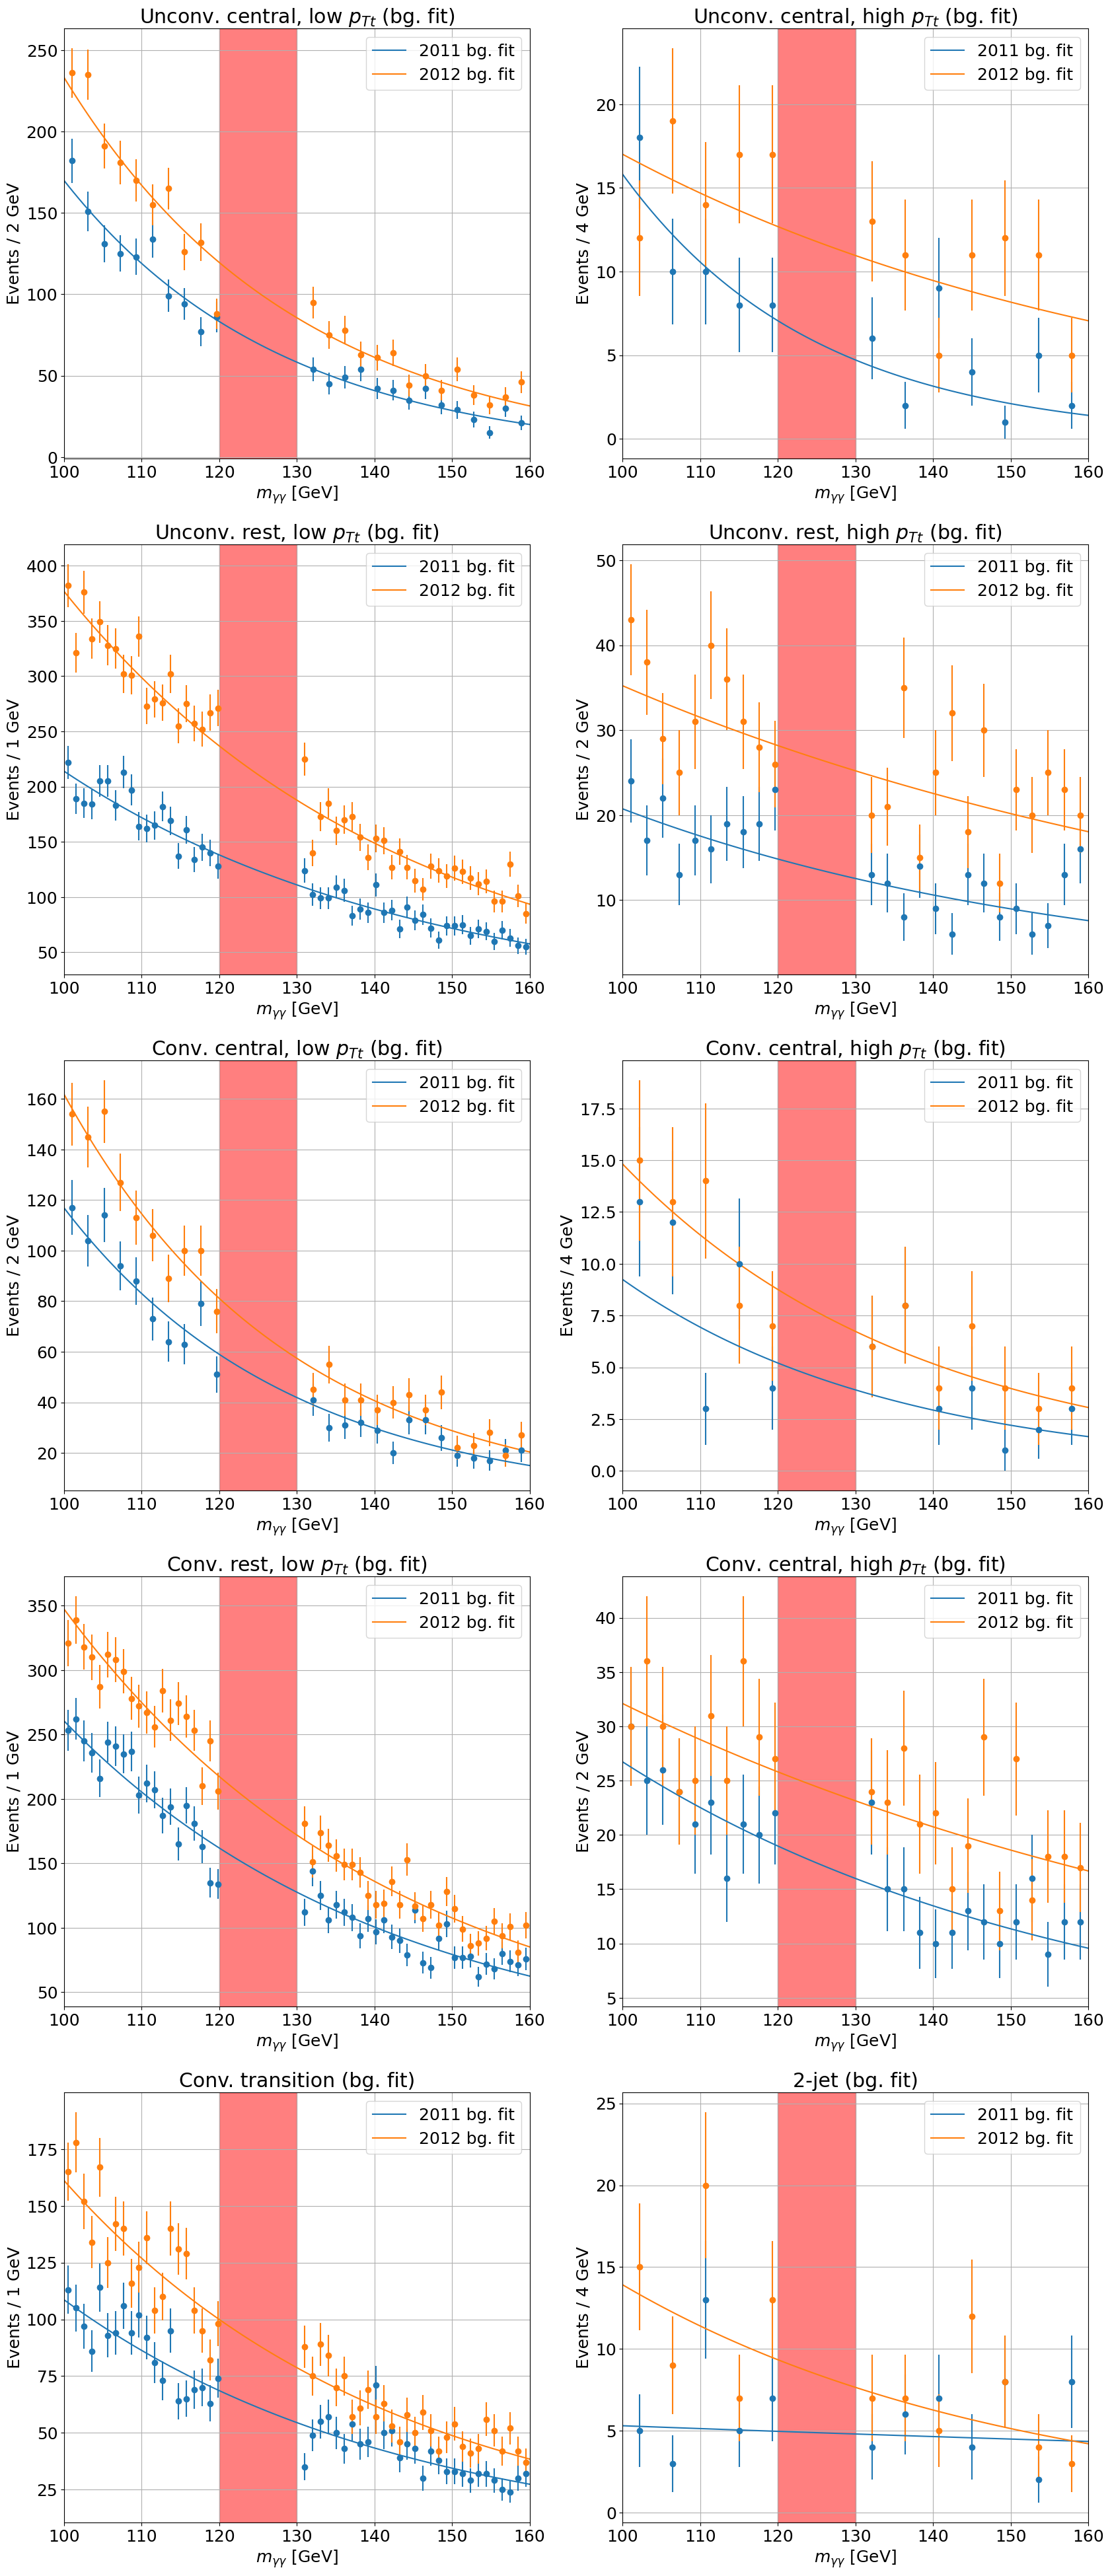

In [92]:
fig2, ax2 = plt.subplots(5, 2, figsize=(20, 50))

for i, ax in enumerate(fig2.axes):
    title = categ_mapping_2011["categ_name"][i].replace("p_{Tt}", "$p_{Tt}$")
    ax.set_title(r"{} (bg. fit)".format(title))
    ax.set_xlabel(r"$m_{\gamma\gamma}$ [GeV]")
    ax.set_ylabel("Events / {} GeV".format(categ_mapping_2011["bin_width_given"][i]))
    
    col = next(ax._get_lines.prop_cycler)['color']
    
    ax.errorbar(
        excluded_2011[2][i]["bins"],
        excluded_2011[2][i]["n"],
        yerr=excluded_2011[2][i]["yerr"],
        fmt='o',
        c=col
    )
    ax.plot(
        np.linspace(100, 160, 100),
        exponential(np.linspace(100, 160, 100),*bg_fit_2011[2][i][0]),
        c=col,
        label="2011 bg. fit"
    )
    
    col = next(ax._get_lines.prop_cycler)['color']

    ax.errorbar(
        excluded_2012[2][i]["bins"],
        excluded_2012[2][i]["n"],
        yerr=excluded_2012[2][i]["yerr"],
        fmt='o',
        c=col
    )
    ax.plot(
        np.linspace(100, 160, 100),
        exponential(np.linspace(100, 160, 100),*bg_fit_2012[2][i][0]),
        c=col,
        label="2012 bg. fit"
    )
    
    ax.add_patch(mpl.patches.Rectangle((120, ax.get_ylim()[0]), 10, ax.get_ylim()[1]-ax.get_ylim()[0], color='red', alpha=0.5))

    
    ax.legend()
    ax.set_xlim(100,160)
    ax.grid(True)

#### Residual
We will now use the calculated background functions to calculate the residuals, which in theory should be the signal.

In [103]:
err_arr_2011 = [np.diag(bg_fit_2011[region][i][1])]

resid_2011 = [[pd.DataFrame({"n":hist_2011[i]["n"]-exponential(hist_2011[i]["bins"],*bg_fit_2011[region][i][0]), "bins":hist_2011[i]["bins"], "yerr":np.sqrt(hist_2011[i]["yerr"]+np.sqrt(bg_fit_2011[region][i][1][1][1]))}) for i in range(10)] for region in range(6)]
resid_2012 = [[pd.DataFrame({"n":hist_2012[i]["n"]-exponential(hist_2012[i]["bins"],*bg_fit_2012[region][i][0]), "bins":hist_2012[i]["bins"], "yerr":np.sqrt(hist_2012[i]["yerr"]+np.sqrt(bg_fit_2012[region][i][1][1][1]))}) for i in range(10)] for region in range(6)]

Plotting the residuals

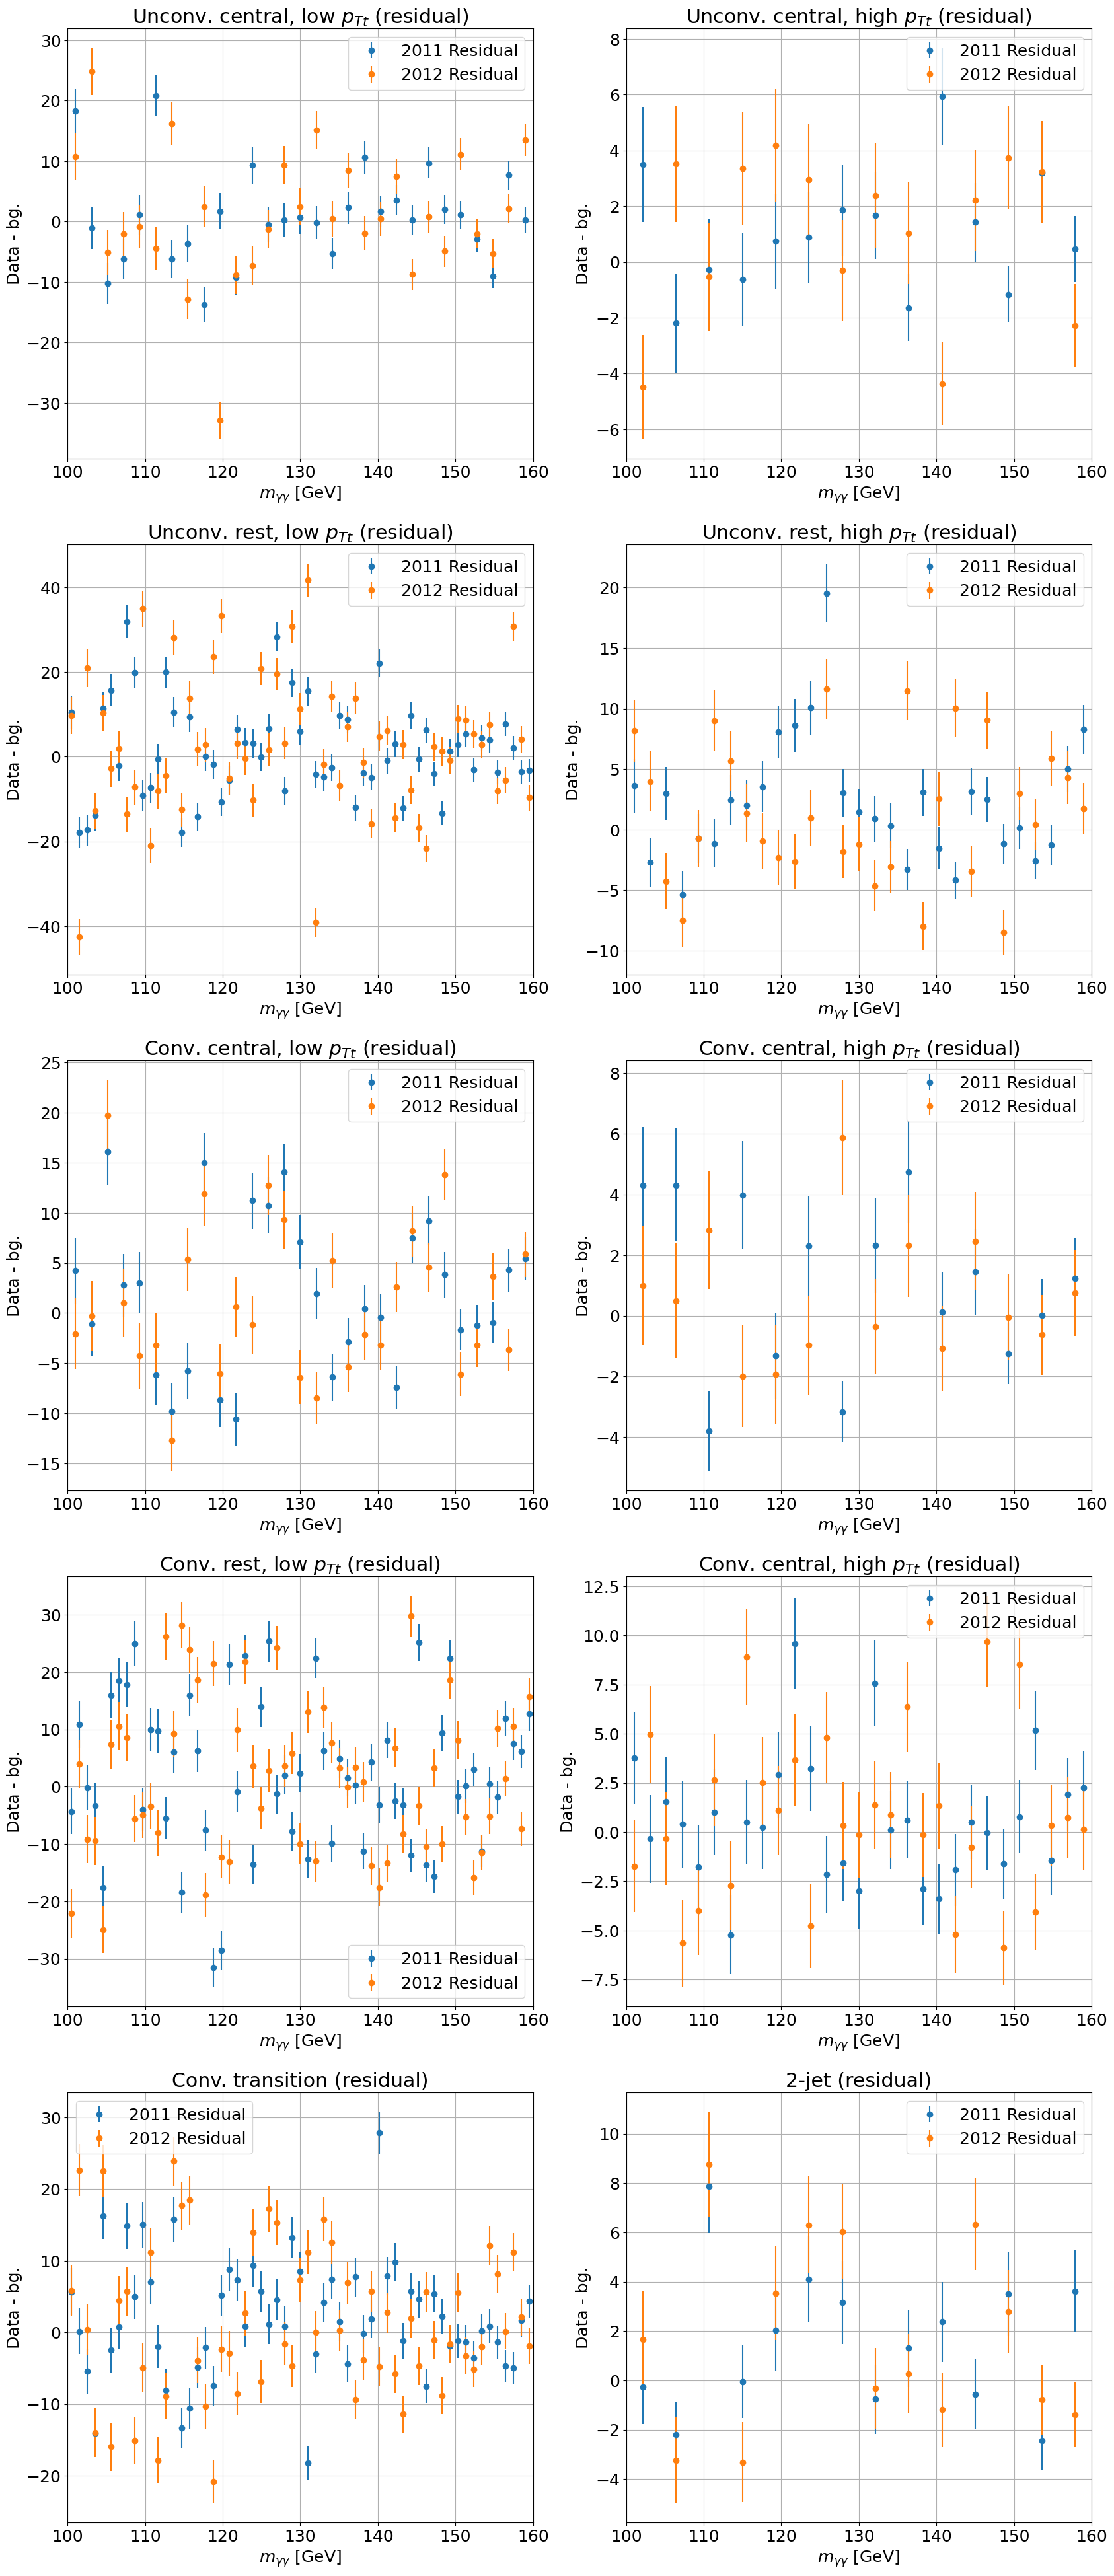

In [105]:
fig3, ax3 = plt.subplots(5, 2, figsize=(20, 50))

for i, ax in enumerate(fig3.axes):
    title = categ_mapping_2011["categ_name"][i].replace("p_{Tt}", "$p_{Tt}$")
    ax.set_title(r"{} (residual)".format(title))
    ax.set_xlabel(r"$m_{\gamma\gamma}$ [GeV]")
    ax.set_ylabel("Data - bg.")
        
    ax.errorbar(
        resid_2011[2][i]["bins"],
        resid_2011[2][i]["n"],
        yerr=resid_2011[2][i]["yerr"],
        fmt='o',
        label="2011 Residual"
    )

    ax.errorbar(
        resid_2012[2][i]["bins"],
        resid_2012[2][i]["n"],
        yerr=resid_2012[2][i]["yerr"],
        fmt='o',
        label="2012 Residual"
    )
    
    ax.legend()
    ax.set_xlim(100,160)
    ax.grid(True)